In [22]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor




In [37]:
# Step 2: Load Dataset
df = pd.read_csv('walmart.csv', parse_dates=['Date'], index_col='Date')


In [9]:
# Step 3: Data Cleaning and Exploration
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
05-02-2010,1,1643690.90,0,42.31,2.572,211.096358,8.106
12-02-2010,1,1641957.44,1,38.51,2.548,211.242170,8.106
19-02-2010,1,1611968.17,0,39.93,2.514,211.289143,8.106
26-02-2010,1,1409727.59,0,46.63,2.561,211.319643,8.106
05-03-2010,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [42]:
# Sort the DataFrame by date
df.sort_values('Date', inplace=True)


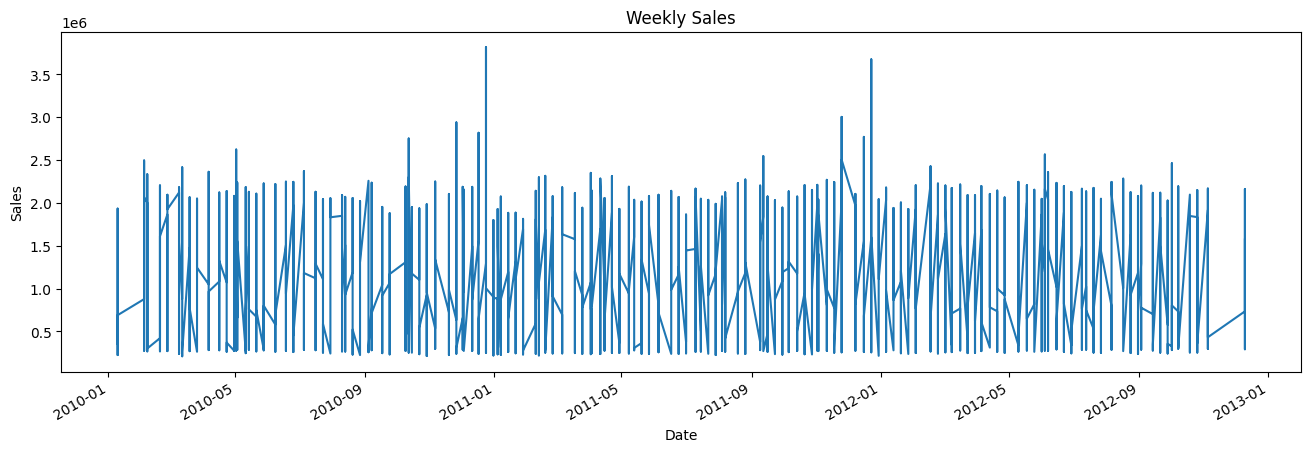

In [45]:
# Step 4: Visualize Data
title = 'Weekly Sales'
ylabel = 'Sales'
xlabel = 'Date'

ax = df['Weekly_Sales'].plot(figsize=(16, 5), title=title, ylabel=ylabel, xlabel=xlabel)
plt.show()


In [11]:

# Step 5: Plotting Holidays
for x in df.query('Holiday_Flag == 1').index:
    ax.axvline(x=x, color='red', alpha=0.3)
plt.show()

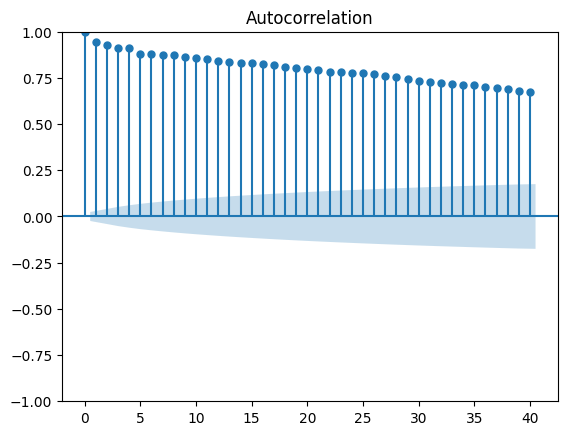

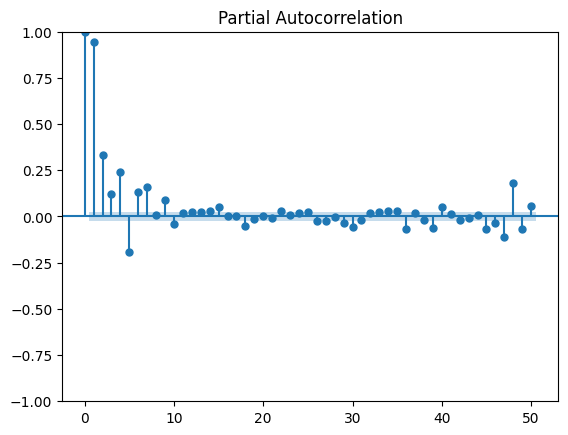

In [12]:

# Step 6: Autocorrelation and Partial Autocorrelation Plots
plot_acf(df['Weekly_Sales'], lags=40)
plt.show()

plot_pacf(df['Weekly_Sales'], lags=50)
plt.show()

<Figure size 640x480 with 0 Axes>

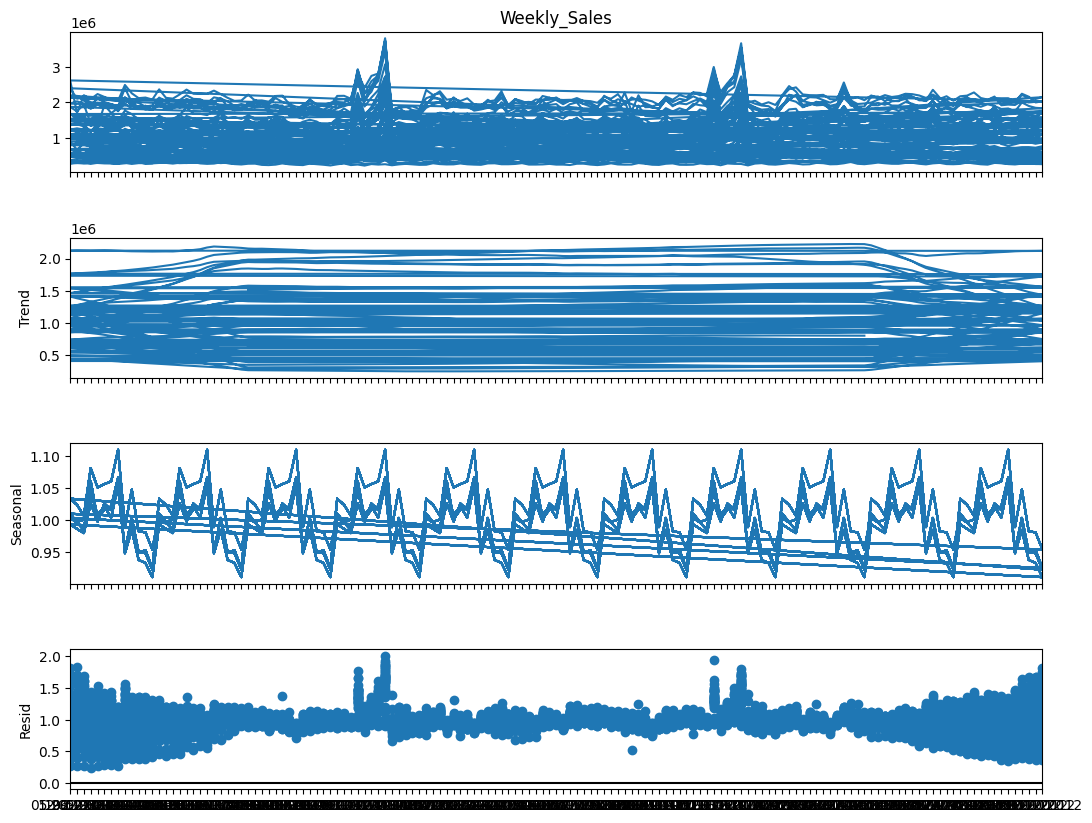

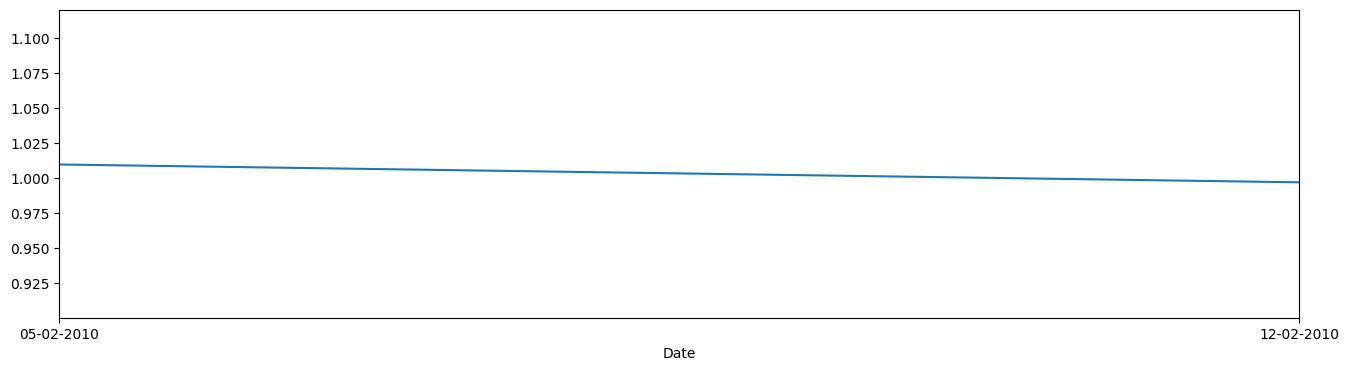

In [13]:

# Step 7: Seasonal Decomposition
result = seasonal_decompose(df['Weekly_Sales'], model='multiplicative', period=52)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)
plt.show()

result.seasonal.plot(figsize=(16, 4), xlim=('2010-02-05', '2013-07-26'))
plt.show()

In [16]:
# Step 8: Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(df['Weekly_Sales'])


Augmented Dickey-Fuller Test: 
ADF test statistic        -4.624149
p-value                    0.000117
# lags used               34.000000
# observations          6400.000000
critical value (1%)       -3.431372
critical value (5%)       -2.861992
critical value (10%)      -2.567010
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [17]:
# Step 9: Splitting into Training and Testing Sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [31]:
# Step 10: SARIMAX Modeling
exog_train, exog_test = train[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']], test[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
model = SARIMAX(train['Weekly_Sales'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 52), enforce_invertibility=False)
results = model.fit(method='nm') 
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                 5148
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood              -69377.393
Date:                            Sat, 30 Dec 2023   AIC                         138774.785
Time:                                    14:46:20   BIC                         138840.147
Sample:                                         0   HQIC                        138797.671
                                           - 5148                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Holiday_Flag  5.957e+04   5102.513     11.674      0.000    4.96e+04    6.96e+04
Temperature  -1195.0553    345.287     -3.461      0.001   -1871.806    -518.305
Fuel_Price   -1.431e+04   8705.952     -1.644      0.100   -3.14e+04    2754.878
CPI          -2402.4767     95.891    -25.054      0.000   -2590.419   -2214.534
Unemployment -6.691e+04   2283.999    -29.294      0.000   -7.14e+04   -6.24e+04
ar.L1            0.9529      0.002    426.174      0.000       0.949       0.957
ma.L1           -0.4467      0.007    -66.018      0.000      -0.460      -0.433
ar.S.L52         0.0040      0.020      0.203      0.839      -0.035       0.043
ma.S.L52        -0.3301      0.017    -19.648      0.000      -0.363      -0.297
sigma2        3.637e+10      0.040   9.04e+11      0.000    3.64e+10    3.64e+10
===================================================================================
Ljung-Box (L1) (Q):                  31.48   Jarque-Bera (JB):             66460.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.15e+25. Standard errors may be unstable.
"""

In [32]:
# Step 11: Forecasting and Evaluation
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end, exog=exog_test).rename('Predictions')

error1 = mse(test['Weekly_Sales'], predictions)
error2 = rmse(test['Weekly_Sales'], predictions)

print(f'SARIMAX MSE Error: {error1:11.10}')
print(f'SARIMAX RMSE Error: {error2:11.10}')


SARIMAX MSE Error: 3.220066911e+11
SARIMAX RMSE Error: 567456.3341


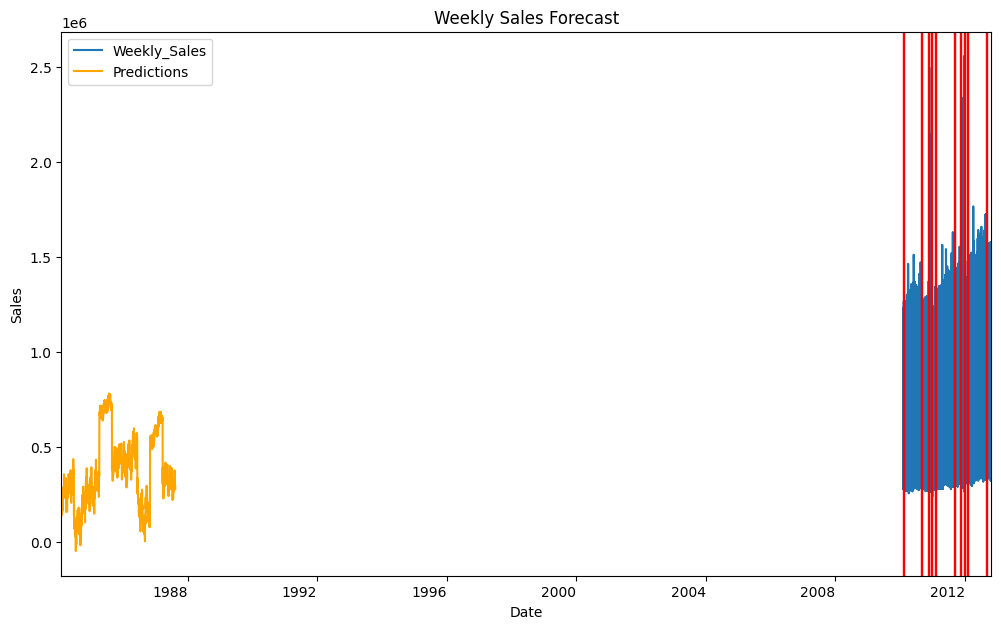

In [55]:
# Step 12: Plotting Forecast
title = 'Weekly Sales Forecast'
ylabel = 'Sales'
xlabel = 'Date'

ax = test['Weekly_Sales'].plot(legend=True, figsize=(12, 8), title=title)
predictions.plot(legend=True, color='orange')
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

for x in test.query('Holiday_Flag == 1').index:
    ax.axvline(x=x, color='red', alpha=0.5)
plt.show()
